In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

res = 1  # 1 km resolution
x_new = np.arange(0, x_grid[-1], res)
y_new = np.arange(0, y_grid[-1], res)
X_new, Y_new = np.meshgrid(x_new, y_new, indexing='ij')
new_points = np.column_stack((X_new.ravel(), Y_new.ravel()))

interp_lon = RegularGridInterpolator((x_grid, y_grid), lon_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)
interp_lat = RegularGridInterpolator((x_grid, y_grid), lat_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)

lon_new = interp_lon(new_points).reshape(len(x_new), len(y_new))
lat_new = interp_lat(new_points).reshape(len(x_new), len(y_new))


In [2]:
df_eddies_true = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_1462_10650.pkl")
df_eddies_true


,Eddy,Day,Cyc,nLon,nLat,nxc,nyc,nic,njc,x0,y0,q11,q12,q22,w,ID,next_num
0,0,1462,AE,160.569072,-28.075269,830.0,1515.0,830,1515,836.867917,1520.899658,0.003011,-0.000090,0.005076,0.016174,0,80179
1,1,1462,AE,155.725082,-27.535036,358.0,1408.0,358,1408,357.723030,1404.524061,0.007987,-0.002294,0.005803,0.027581,1,80179
2,2,1462,CE,161.070068,-29.736625,928.0,1356.0,928,1356,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293,2,80179
3,3,1462,CE,156.973832,-28.452969,506.0,1354.0,506,1354,510.292455,1353.033146,-0.008094,0.001176,-0.006943,-0.030074,3,80179
4,4,1462,AE,159.170505,-29.807511,754.0,1285.0,754,1285,752.203674,1287.290040,0.005505,-0.001515,0.003850,0.018711,4,80179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412607,24,10650,AE,151.460338,-38.218269,349.0,158.0,349,158,347.972729,164.451434,0.008346,0.000024,0.004795,0.026282,79959,80179
412608,25,10650,CE,158.194230,-40.416548,973.0,126.0,973,126,975.638390,122.704594,-0.000453,0.000232,-0.001166,-0.003239,80161,80179
412609,26,10650,AE,156.242892,-40.165033,805.0,95.0,805,95,803.196837,96.977325,0.002822,0.000897,0.002131,0.009906,80113,80179
412610,27,10650,CE,148.933514,-38.691752,157.0,34.0,157,34,143.141637,36.258489,-0.001199,-0.000704,-0.001818,-0.006034,79900,80179


In [3]:
df_eddies = df_eddies_true.sort_values(by=['ID', 'Day']).drop('Eddy', axis=1).drop('next_num', axis=1).copy()
df_eddies = df_eddies[df_eddies.groupby('ID')['ID'].transform('count') >= 21] # 3 Weeks
df_eddies['ID'] = df_eddies['ID'].rank(method='dense').astype(int)
df_eddies = df_eddies[['ID'] + [col for col in df_eddies.columns if col != 'ID']]
# Find Lon and Lat values
xg, yg = X_new.T[0, :], Y_new.T[:, 0] 
lon_interp = RegularGridInterpolator((yg, xg), lon_new.T, bounds_error=False, fill_value=np.nan)
lat_interp = RegularGridInterpolator((yg, xg), lat_new.T, bounds_error=False, fill_value=np.nan)
points = np.column_stack((df_eddies['y0'], df_eddies['x0']))
lon_vals, lat_vals = lon_interp(points), lat_interp(points)
df_eddies['Lon'], df_eddies['Lat'] = lon_vals, lat_vals
cols = list(df_eddies.columns)
njc_idx = cols.index('njc')
new_order = cols[:njc_idx + 1] + ['Lon', 'Lat'] + [col for col in cols if col not in ['Lon', 'Lat'] and col not in cols[:njc_idx + 1]]
df_eddies = df_eddies[new_order]
df_eddies = df_eddies.reset_index(drop=True)

df_eddies = df_eddies.drop(columns=[col for col in df_eddies.columns if col.startswith('n')]).copy() # Drop Nencioli data
df_eddies


,ID,Day,Cyc,Lon,Lat,x0,y0,q11,q12,q22,w
0,1,1462,CE,161.093546,-29.714998,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293
1,1,1463,CE,160.871720,-29.764770,910.409810,1346.368459,-0.006279,0.001039,-0.002655,-0.017868
2,1,1464,CE,160.922307,-29.791470,915.918179,1345.231552,-0.003853,0.000654,-0.002549,-0.012804
3,1,1465,CE,160.955011,-29.644446,914.513286,1361.918280,-0.004816,0.001225,-0.003001,-0.015635
4,1,1466,CE,160.900960,-29.634113,909.171353,1361.201101,-0.003874,0.001326,-0.003299,-0.014347
...,...,...,...,...,...,...,...,...,...,...,...
117851,2962,10646,CE,155.090978,-40.102161,708.322310,67.634123,-0.002455,-0.000032,-0.001645,-0.008201
117852,2962,10647,CE,154.836115,-40.385267,695.611882,30.128608,-0.001272,0.000185,-0.001351,-0.005245
117853,2962,10648,CE,154.979715,-40.569836,712.690769,14.777712,-0.001122,0.000260,-0.001881,-0.006006
117854,2962,10649,CE,155.150873,-40.263961,717.914731,52.244946,-0.001737,-0.000091,-0.001655,-0.006783


In [4]:
def interpolate_eddy_tracks(df):
    df = df.copy()
    df_interp = []

    for eddy_id, group in df.groupby('ID'):
        # Build a full range of days for this eddy
        full_days = pd.DataFrame({'Day': range(group['Day'].min(), group['Day'].max() + 1)})
        full_days['ID'] = eddy_id

        # Merge to reindex with all days, keeping columns of interest
        merged = pd.merge(full_days, group, on=['ID', 'Day'], how='left')

        # Interpolate numerical columns
        merged['Lon'] = merged['Lon'].interpolate()
        merged['Lat'] = merged['Lat'].interpolate()
        merged['x0'] = merged['x0'].interpolate()
        merged['y0'] = merged['y0'].interpolate()

        # Fill categorical column
        merged['Cyc'] = merged['Cyc'].ffill().bfill()

        df_interp.append(merged)

    df_result = pd.concat(df_interp, ignore_index=True).sort_values(by=['ID', 'Day'])

    return df_result
df_eddies = interpolate_eddy_tracks(df_eddies)
df_eddies['Age'] = df_eddies.groupby('ID')['ID'].transform('count')
fnames = [
    f"/srv/scratch/z3533156/26year_BRAN2020/outer_avg_{1461 + ((day - 1462) // 30) * 30:05}.nc"
    for day in df_eddies['Day']
]
df_eddies['fname'] = fnames
# Find closest grid points
from scipy.spatial import cKDTree
points = np.column_stack((X_grid.ravel(), Y_grid.ravel()))
tree = cKDTree(points)
x0s = df_eddies['x0'].to_numpy()
y0s = df_eddies['y0'].to_numpy()
query_points = np.column_stack((x0s, y0s))
_, indices = tree.query(query_points)
ics, jcs = np.unravel_index(indices, X_grid.shape)
ics = ics.astype(int)
jcs = jcs.astype(int)
insert_at = df_eddies.columns.get_loc('Lat') + 1
df_eddies.insert(insert_at, 'ic', ics)
df_eddies.insert(insert_at + 1, 'jc', jcs)
df_eddies


,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
0,1462,1,CE,161.093546,-29.714998,261,275,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1463,1,CE,160.871720,-29.764770,258,273,910.409810,1346.368459,-0.006279,0.001039,-0.002655,-0.017868,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1464,1,CE,160.922307,-29.791470,259,272,915.918179,1345.231552,-0.003853,0.000654,-0.002549,-0.012804,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1465,1,CE,160.955011,-29.644446,259,276,914.513286,1361.918280,-0.004816,0.001225,-0.003001,-0.015635,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1466,1,CE,160.900960,-29.634113,258,276,909.171353,1361.201101,-0.003874,0.001326,-0.003299,-0.014347,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132634,10646,2962,CE,155.090978,-40.102161,223,14,708.322310,67.634123,-0.002455,-0.000032,-0.001645,-0.008201,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132635,10647,2962,CE,154.836115,-40.385267,220,6,695.611882,30.128608,-0.001272,0.000185,-0.001351,-0.005245,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132636,10648,2962,CE,154.979715,-40.569836,223,3,712.690769,14.777712,-0.001122,0.000260,-0.001881,-0.006006,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132637,10649,2962,CE,155.150873,-40.263961,224,11,717.914731,52.244946,-0.001737,-0.000091,-0.001655,-0.006783,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [5]:
df_eddies.to_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")


In [6]:
duplicates = df_eddies[df_eddies.duplicated(subset=['ID', 'Day'], keep=False)]
duplicates

,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname


(np.float64(7.359095973834592),
 np.float64(1045.2497596421324),
 np.float64(-110.66291419930491),
 np.float64(1655.999221024783))

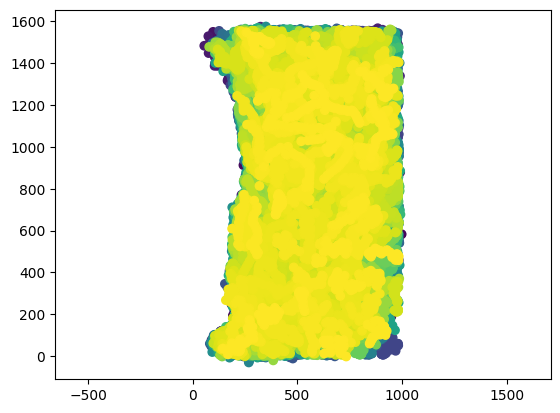

In [7]:
plt.scatter(df_eddies['x0'], df_eddies['y0'], c=df_eddies['ID'])
# plt.plot(df_eddies['x0'], df_eddies['y0'])
plt.axis('equal')

(np.float64(7.359095973834592),
 np.float64(1045.2497596421324),
 np.float64(-110.66291419930491),
 np.float64(1655.999221024783))

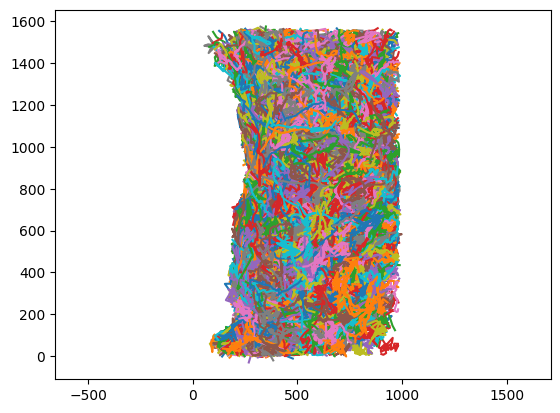

In [8]:
for ID in df_eddies['ID'].unique():
    df = df_eddies[df_eddies['ID']==ID].copy()
    plt.plot(df['x0'], df['y0'])
plt.axis('equal')

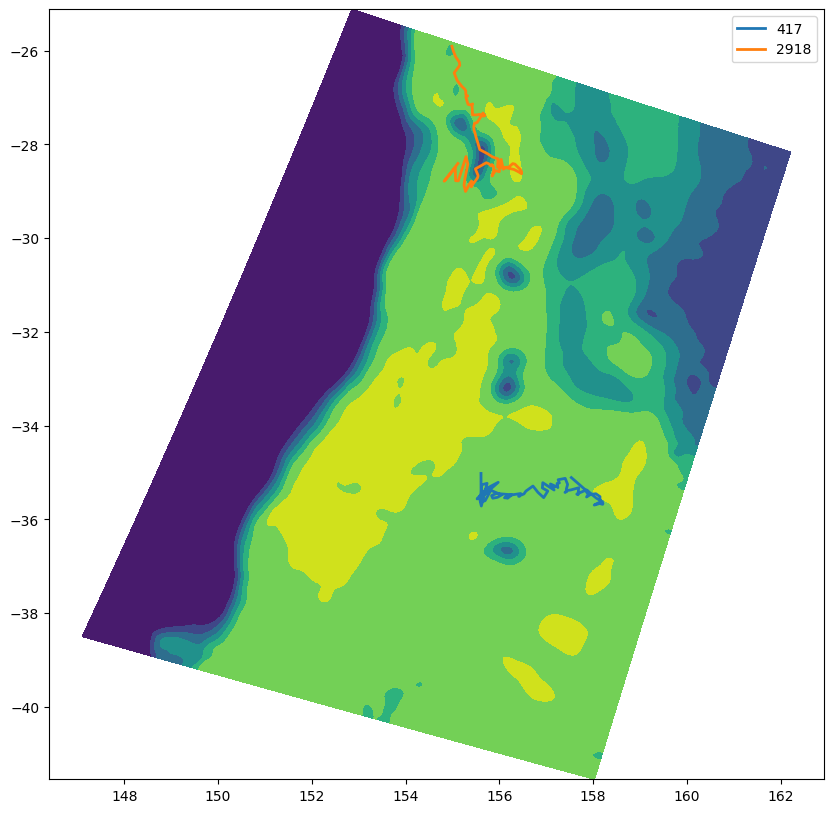

In [9]:
plt.figure(figsize=(10,10))

plt.contourf(lon_rho, lat_rho, h)

for ID in df_eddies['ID'].unique():
    df = df_eddies[df_eddies['ID']==ID].copy()

    # if (df.iloc[0]['Age'] >= 73) and (df.iloc[0]['Age'] <= 78):
    if df.iloc[0]['Age'] == 85:

        if df.iloc[0]['Cyc'] == 'AE':

            # if df.iloc[0]['ID'] == 382:
            plt.plot(df['Lon'], df['Lat'], label=ID, linewidth=2)
        
plt.axis('equal')
plt.legend()


In [11]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

#### Tracking Parameters

In [ ]:
df_R = pd.read_pickle(f"/srv/scratch/z5297792/Chapter2/df_R_1462_10650.pkl")
df_R


In [ ]:
df_R[df_R['R']<=200]['R'].hist(bins=1000) # NEED TO MAKE IT 50 !!!!!!
plt.axvline(x=50, color='r') 
plt.xlabel('R')
plt.ylabel('Frequency')
# plt.xlim(0, 100)
plt.show()

In [ ]:
df_R[df_R['D_diff']<=200]['D_diff'].hist(bins=1000)
# plt.axvline(x=30, color='r')
plt.xlabel(r'$\Delta$D')
plt.ylabel('Frequency')
# plt.xlim(0, 100)
plt.show()

In [ ]:
df_R['W_diff'].hist(bins=1000)
# plt.axvline(x=30, color='r')
plt.xlabel(r'$\Delta\omega$')
plt.ylabel('Frequency')
# plt.xlim(0, 100)
plt.show()